In [1]:
!pip install captum
!pip install drive/MyDrive/encoder_attribution_priors/.

Processing ./drive/MyDrive/encoder_attribution_priors
  Preparing metadata (setup.py) ... done
  Created wheel for lfxai: filename=lfxai-0.1.1-py3-none-any.whl size=30360 sha256=1e9d2336debf2bdea4403858dc8cd2e3c69280752ba4055bf3b3b6efb6a5cbc7
  Stored in directory: /tmp/pip-ephem-wheel-cache-6jhnshtd/wheels/7b/00/41/6fc986ab56840bbe22a1da3b92c41c9d55e2dcd851163270b7
Successfully built lfxai
  Attempting uninstall: lfxai
    Found existing installation: lfxai 0.1.1
    Uninstalling lfxai-0.1.1:
      Successfully uninstalled lfxai-0.1.1


In [2]:
import argparse
import csv
import itertools
import logging
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
from captum.attr import GradientShap, IntegratedGradients, Saliency
from scipy.stats import spearmanr
from torch.utils.data import DataLoader, RandomSampler, Subset
from torchvision import transforms

from lfxai.explanations.examples import (
    InfluenceFunctions,
    NearestNeighbours,
    SimplEx,
    TracIn,
)
from lfxai.explanations.features import attribute_auxiliary, attribute_individual_dim
from lfxai.models.images import (
    VAE,
    AutoEncoderMnist,
    ClassifierMnist,
    DecoderBurgess,
    DecoderMnist,
    EncoderBurgess,
    EncoderMnist,
)
from lfxai.models.losses import BetaHLoss, BtcvaeLoss, EntropyLoss
from lfxai.models.pretext import Identity, Mask, RandomNoise
from lfxai.utils.datasets import MaskedMNIST
from lfxai.utils.feature_attribution import generate_masks
from lfxai.utils.metrics import (
    compute_metrics,
    cos_saliency,
    count_activated_neurons,
    entropy_saliency,
    pearson_saliency,
    similarity_rates,
    spearman_saliency,
)
from lfxai.utils.visualize import (
    correlation_latex_table,
    plot_pretext_saliencies,
    plot_pretext_top_example,
    plot_vae_saliencies,
    vae_box_plots,
)

In [3]:
def disvae_feature_importance(
    random_seed: int = 1,
    batch_size: int = 300,
    n_plots: int = 20,
    #n_runs: int = 5,
    n_runs: int = 2,
    dim_latent: int = 3,
    #n_epochs: int = 100,
    n_epochs: int = 5,
    #beta_list: list = [1, 5, 10],
    beta_list: list = [1],
) -> None:
    # Initialize seed and device
    np.random.seed(random_seed)
    torch.random.manual_seed(random_seed)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Load MNIST
    W = 32
    img_size = (1, W, W)
    data_dir = Path.cwd() / "drive/MyDrive/encoder_attribution_priors/experiments/data/mnist"
    train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
    test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)
    train_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
    test_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
    train_dataset.transform = train_transform
    test_dataset.transform = test_transform
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Create saving directory
    save_dir = Path.cwd() / "drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/vae"
    if not save_dir.exists():

        print(f"Creating saving directory {save_dir}")
        os.makedirs(save_dir)

    # Define the computed metrics and create a csv file with appropriate headers
    loss_list = [EntropyLoss(alpha=100), BetaHLoss(), BtcvaeLoss(is_mss=False, n_data=len(train_dataset))]
    metric_list = [
        pearson_saliency,
        spearman_saliency,
        cos_saliency,
        entropy_saliency,
        count_activated_neurons,
    ]
    metric_names = [
        "Pearson Correlation",
        "Spearman Correlation",
        "Cosine",
        "Entropy",
        "Active Neurons",
    ]
    headers = ["Loss Type", "Beta"] + metric_names
    csv_path = save_dir / "metrics.csv"
    if not csv_path.is_file():
        print(f"Creating metrics csv in {csv_path}")

        with open(csv_path, "w") as csv_file:
            dw = csv.DictWriter(csv_file, delimiter=",", fieldnames=headers)
            dw.writeheader()

    for beta, loss, run in itertools.product(
        beta_list, loss_list, range(1, n_runs + 1)
    ):
        # Initialize vaes
        encoder = EncoderBurgess(img_size, dim_latent)
        decoder = DecoderBurgess(img_size, dim_latent)
        loss.beta = beta
        name = f"{str(loss)}-vae_beta{beta}_run{run}"
        model = VAE(img_size, encoder, decoder, dim_latent, loss, name=name)
        print(f"Now fitting {name}")

        model.fit(device, train_loader, test_loader, save_dir, n_epochs)
        model.load_state_dict(torch.load(save_dir / (name + ".pt")), strict=False)

        # Compute test-set saliency and associated metrics
        baseline_image = torch.zeros((1, 1, W, W), device=device)
        gradshap = GradientShap(encoder.mu)
        attributions = attribute_individual_dim(
            encoder.mu, dim_latent, test_loader, device, gradshap, baseline_image
        )
        metrics = compute_metrics(attributions, metric_list)
        results_str = "\t".join(
            [f"{metric_names[k]} {metrics[k]:.2g}" for k in range(len(metric_list))]
        )
        print(f"Model {name} \t {results_str}")


        # Save the metrics
        with open(csv_path, "a", newline="") as csv_file:
            writer = csv.writer(csv_file, delimiter=",")
            writer.writerow([str(loss), beta] + metrics)

        # Plot a couple of examples
        plot_idx = [
            torch.nonzero(test_dataset.targets == (n % 10))[n // 10].item()
            for n in range(n_plots)
        ]
        images_to_plot = [test_dataset[i][0].numpy().reshape(W, W) for i in plot_idx]
        fig = plot_vae_saliencies(images_to_plot, attributions[plot_idx])
        fig.savefig(save_dir / f"{name}.pdf")
        plt.close(fig)

    fig = vae_box_plots(pd.read_csv(csv_path), metric_names)
    fig.savefig(save_dir / "metric_box_plots.pdf")
    plt.close(fig)

In [ ]:
disvae_feature_importance()

Now fitting Entropy-vae_beta1_run1


Model Entropy-vae_beta1_run1 	 Pearson Correlation 0.52	Spearman Correlation 0.99	Cosine 0.82	Entropy 0.066	Active Neurons 1
Now fitting Entropy-vae_beta1_run2


Model Entropy-vae_beta1_run2 	 Pearson Correlation 0.38	Spearman Correlation 0.99	Cosine 0.73	Entropy 0.22	Active Neurons 1
Now fitting Beta-vae_beta1_run1


Model Beta-vae_beta1_run1 	 Pearson Correlation 0.42	Spearman Correlation 0.99	Cosine 0.73	Entropy 0.45	Active Neurons 1.3
Now fitting Beta-vae_beta1_run2


Model Beta-vae_beta1_run2 	 Pearson Correlation 0.33	Spearman Correlation 0.98	Cosine 0.62	Entropy 0.74	Active Neurons 1.3
Now fitting TC-vae_beta1_run1


Model TC-vae_beta1_run1 	 Pearson Correlation 0.31	Spearman Correlation 0.99	Cosine 0.63	Entropy 0.74	Active Neurons 1.3
Now fitting TC-vae_beta1_run2


Model TC-vae_beta1_run2 	 Pearson Correlation 0.31	Spearman Correlation 0.98	Cosine 0.61	Entropy 0.72	Active Neurons 1.3


In [5]:
def entropy_vae(
    random_seed: int = 1,
    batch_size: int = 300,
    n_plots: int = 20,
    n_runs: int = 1,
    dim_latent: int = 3,
    n_epochs: int = 2,
    alpha_list: list = [1, 5, 10],
) -> None:
    # Initialize seed and device
    np.random.seed(random_seed)
    torch.random.manual_seed(random_seed)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Load MNIST
    W = 32
    img_size = (1, W, W)
    data_dir = Path.cwd() / "drive/MyDrive/encoder_attribution_priors/experiments/data/mnist"
    train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
    test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)
    train_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
    test_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
    train_dataset.transform = train_transform
    test_dataset.transform = test_transform
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Create saving directory
    save_dir = Path.cwd() / "drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/entropy_vae"
    if not save_dir.exists():

        print(f"Creating saving directory {save_dir}")
        os.makedirs(save_dir)

    # Define the computed metrics and create a csv file with appropriate headers
    loss_list = [EntropyLoss()]
    metric_list = [
        pearson_saliency,
        entropy_saliency,
        count_activated_neurons,
    ]
    metric_names = [
        "Pearson Correlation",
        "Entropy",
        "Active Neurons",
    ]
    headers = ["Loss Type", "Alpha"] + metric_names
    csv_path = save_dir / "metrics.csv"
    if not csv_path.is_file():
        print(f"Creating metrics csv in {csv_path}")

        with open(csv_path, "w") as csv_file:
            dw = csv.DictWriter(csv_file, delimiter=",", fieldnames=headers)
            dw.writeheader()

    for alpha, loss, run in itertools.product(
        alpha_list, loss_list, range(1, n_runs + 1)
    ):
        # Initialize vaes
        encoder = EncoderBurgess(img_size, dim_latent)
        decoder = DecoderBurgess(img_size, dim_latent)
        loss.alpha = alpha
        name = f"{str(loss)}-vae_alpha{alpha}_run{run}"
        model = VAE(img_size, encoder, decoder, dim_latent, loss, name=name)
        print(f"Now fitting {name}")

        model.fit(device, train_loader, test_loader, save_dir, n_epochs)
        model.load_state_dict(torch.load(save_dir / (name + ".pt")), strict=False)

        # Compute test-set saliency and associated metrics
        baseline_image = torch.zeros((1, 1, W, W), device=device)
        gradshap = GradientShap(encoder.mu)
        attributions = attribute_individual_dim(
            encoder.mu, dim_latent, test_loader, device, gradshap, baseline_image
        )
        metrics = compute_metrics(attributions, metric_list)
        results_str = "\t".join(
            [f"{metric_names[k]} {metrics[k]:.2g}" for k in range(len(metric_list))]
        )
        print(f"Model {name} \t {results_str}")


        # Save the metrics
        with open(csv_path, "a", newline="") as csv_file:
            writer = csv.writer(csv_file, delimiter=",")
            writer.writerow([str(loss), alpha] + metrics)

        # Plot a couple of examples
        plot_idx = [
            torch.nonzero(test_dataset.targets == (n % 10))[n // 10].item()
            for n in range(n_plots)
        ]
        images_to_plot = [test_dataset[i][0].numpy().reshape(W, W) for i in plot_idx]
        fig = plot_vae_saliencies(images_to_plot, attributions[plot_idx])
        fig.savefig(save_dir / f"{name}.pdf")
        plt.close(fig)

    fig = vae_box_plots(pd.read_csv(csv_path), metric_names)
    fig.savefig(save_dir / "metric_box_plots.pdf")
    plt.close(fig)

Creating saving directory /content/drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/entropy_vae
Creating metrics csv in /content/drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/entropy_vae/metrics.csv
Now fitting Entropy-vae_alpha1_run1


Epoch 1/2 	 
Train loss 304 	 Test loss 260 	 


Epoch 2/2 	 
Train loss 257 	 Test loss 252 	 
Model Entropy-vae_alpha1_run1 	 Pearson Correlation 0.43	Entropy 0.073	Active Neurons 1
Now fitting Entropy-vae_alpha5_run1


Epoch 1/2 	 
Train loss 311 	 Test loss 265 	 


Epoch 2/2 	 
Train loss 258 	 Test loss 252 	 
Model Entropy-vae_alpha5_run1 	 Pearson Correlation 0.47	Entropy 0.039	Active Neurons 1
Now fitting Entropy-vae_alpha10_run1


Epoch 1/2 	 
Train loss 313 	 Test loss 272 	 


Epoch 2/2 	 
Train loss 265 	 Test loss 253 	 
Model Entropy-vae_alpha10_run1 	 Pearson Correlation 0.56	Entropy 0.098	Active Neurons 1


ValueError: ignored

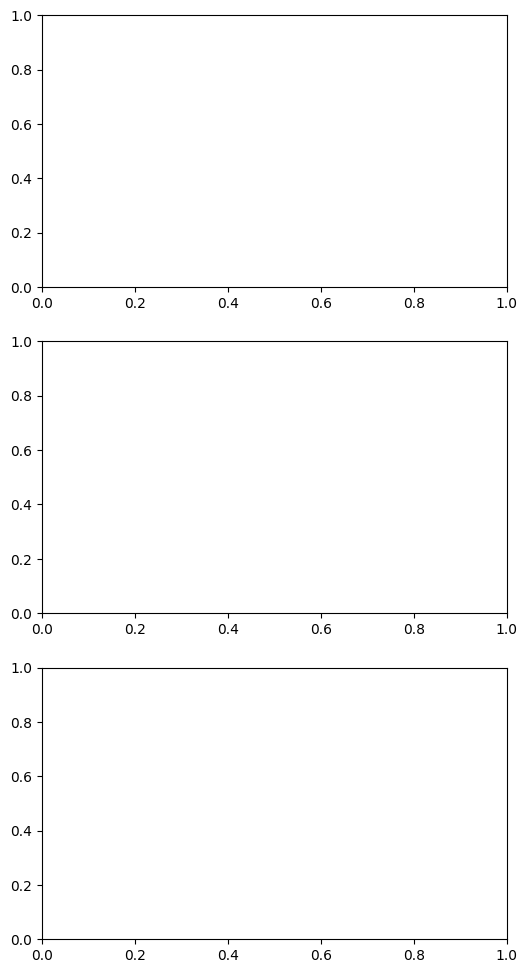

In [6]:
entropy_vae()